In [2]:
import numpy as np
import pandas as pd
from interactions_data import create_index, reset_ids
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import zipfile
import os, shutil

In [4]:
try:
    shutil.rmtree('./ml-10M100K')
    print('ml-10M100K directory already exists, removing it first')
except:
    print('no existing directory found, all good')

# stable link for dataset
url = 'http://files.grouplens.org/datasets/movielens/'
filename = 'ml-10m.zip'

# download zip file from link
print('downloading and saving dataset from movielens stable link...')
downloaded = urlopen(url + filename)
buf = downloaded.read()

# save file and extract contents
with open(filename, 'wb') as f:
    f.write(buf)

print('unzipping contents')
with zipfile.ZipFile(filename) as zip:
    zip.extractall('.')
    
# remove zip file from directory
print('deleting zip file')
os.remove('ml-10m.zip')

downloading and saving dataset from movielens stable link...
unzipping contents


In [6]:
path = 'ml-10M100K/'

In [7]:
df = pd.read_csv(path+'ratings.dat',
                 sep='::',
                 names=['userId', 'movieId', 'rating', 'timestamp'],
                 engine='python').drop('timestamp', axis=1)

In [8]:
df.head()

,userId,movieId,rating
0,1,122,5.0
1,1,185,5.0
2,1,231,5.0
3,1,292,5.0
4,1,316,5.0


In [10]:
df.shape

(10000054, 3)

In [9]:
movies = pd.read_csv(path+'movies.dat',
                     sep='::',
                     names=['movieId', 'title', 'genres'],
                     engine='python')

tags = pd.read_csv(path+'tags.dat',
                   sep='::',
                   names=['userId', 'movieId', 'tag', 'timestamp'],
                   engine='python')

In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
movies.shape

(10681, 3)

In [13]:
tags.head()

,userId,movieId,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


In [14]:
tags.shape

(95580, 4)

In [15]:
user_ids = df['userId'].unique()
movie_ids = df['movieId'].unique()

In [16]:
# length before
print(len(movies))

# keep metadata only for movies that have receieved ratings
movies = movies[movies['movieId'].isin(movie_ids)]
tags = tags[tags['movieId'].isin(movie_ids)]
tags = tags[tags['userId'].isin(user_ids)]

# length after
print(len(movies))

10681
10677


In [17]:
# create ID encoders
user_encoder, _ = create_index(user_ids)
movie_encoder, _ = create_index(movie_ids)

### Encode IDs from 0-n

In [18]:
# replace all IDs with sequential 0-N IDs
df['userId'] = df['userId'].apply(lambda x: user_encoder[x])
df['movieId'] = df['movieId'].apply(lambda x: movie_encoder[x])

tags['userId'] = tags['userId'].apply(lambda x: user_encoder[x])
tags['movieId'] = tags['movieId'].apply(lambda x: movie_encoder[x])

movies['movieId'] = movies['movieId'].apply(lambda x: movie_encoder[x])

In [19]:
n_users = df.userId.nunique()
n_items = df.movieId.nunique()
max_score = df.rating.max()
min_score = df.rating.min()

In [20]:
print(n_users, df.userId.max())
print(n_items, df.movieId.max())
print(min_score, max_score)

69878 69877
10677 10676
0.5 5.0


### Train / test split

In [21]:
train, test, _, _ = train_test_split(df, df.rating,
                                     test_size = .2,
                                     random_state=42,
                                     stratify=df.userId)

In [22]:
# split train into 2 files to allow github storage
train1, train2, _, _ = train_test_split(train, train.rating,
                                       test_size = .5,
                                       random_state=42)

In [23]:
train1.shape, train2.shape

((4000021, 3), (4000022, 3))

In [24]:
test.shape

(2000011, 3)

In [25]:
train1.to_csv(path+'train1.csv', index=False)
train2.to_csv(path+'train2.csv', index=False)
test.to_csv(path+'test.csv', index=False)

In [27]:
movies.to_csv(path+'movies.csv', index=False)
tags.to_csv(path+'tags.csv', index=False)

### remove all other files

In [26]:
dir_name = "./ml-10M100K/"
folder = os.listdir(dir_name)

for item in folder:
    if not (item.endswith(".csv") or item.endswith(".html")):
        os.remove(os.path.join(dir_name, item))

## EDA

In [28]:
from glob import glob
ratings = ['train1.csv', 'train2.csv', 'test.csv']

In [31]:
# load all of train and test data as one dataframe
df = pd.concat((pd.read_csv(path+file) for file in ratings), ignore_index=True)
movies = pd.read_csv(path+'movies.csv')

# create one merged DataFrame
df = pd.merge(movies, df)[['userId','movieId','rating','title']]

In [32]:
df.shape

(10000054, 4)

In [33]:
df.head()

,userId,movieId,rating,title
0,32547,96,4.0,Toy Story (1995)
1,40597,96,3.0,Toy Story (1995)
2,11624,96,3.0,Toy Story (1995)
3,31748,96,1.5,Toy Story (1995)
4,40982,96,3.0,Toy Story (1995)


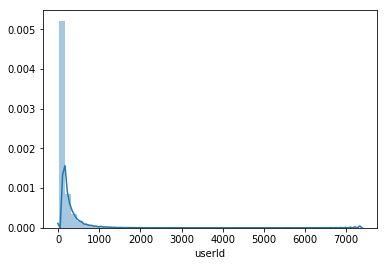

Max ratings by single user: 7359
Min ratings by single user: 20
Avg number of ratings per user: 143


In [34]:
user_counts = df['userId'].value_counts()

sns.distplot(user_counts)
plt.show()

# user with fewest ratings
print('Min ratings by single user:',
      user_counts.min())

# user with most ratings
print('Max ratings by single user:',
      user_counts.max())

# average number of ratings per user
print('Avg number of ratings per user:',
      round(user_counts.mean()))

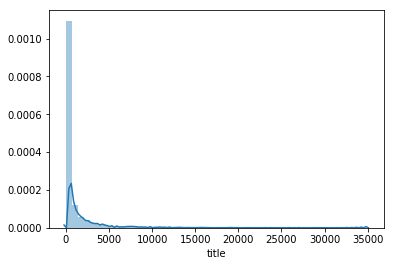

Min ratings of single movie: 1
Max ratings of single movie: 34864
Avg number of ratings per movie: 937


In [35]:
movie_counts = df['title'].value_counts()

sns.distplot(movie_counts)
plt.show()

# movie with fewest ratings
print('Min ratings of single movie:',
      movie_counts.min())

# movie with most ratings
print('Max ratings of single movie:',
      movie_counts.max())

# average number of ratings per book
print('Avg number of ratings per movie:',
      round(movie_counts.mean()))

In [36]:
movie_counts.head()

Pulp Fiction (1994)                 34864
Forrest Gump (1994)                 34457
Silence of the Lambs, The (1991)    33668
Jurassic Park (1993)                32631
Shawshank Redemption, The (1994)    31126
Name: title, dtype: int64

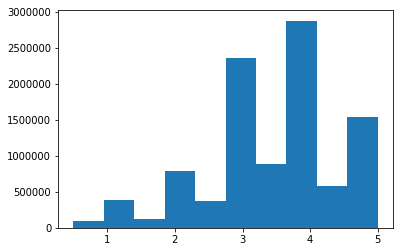

Avg rating: 3.51


In [37]:
plt.hist(df['rating'].values)
plt.show()

print('Avg rating:', round(df['rating'].mean(),2))